# Architecture of Camera Radar Fusion Tracking
![Architecture of Camera Radar Fusion Tracking](../media/architecture_of_camerar_radar_tracking.png)

In [383]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nuscenes.utils.data_classes import RadarPointCloud, view_points
from pyquaternion import Quaternion
from sklearn.cluster import DBSCAN
from PIL import Image

from sort import Sort

In [384]:
# instance of sort
mot_tracker = Sort() 

In [385]:
!ls | grep jpg

n008-2018-08-01-15-16-36-0400__CAM_FRONT__1533151603512404.jpg
n008-2018-08-01-15-16-36-0400__CAM_FRONT__1533151604012404.jpg
n008-2018-08-01-15-16-36-0400__CAM_FRONT__1533151604512404.jpg
n008-2018-08-01-15-16-36-0400__CAM_FRONT__1533151605012404.jpg


In [386]:
# read image
im1 = Image.open('n008-2018-08-01-15-16-36-0400__CAM_FRONT__1533151603512404.jpg')
im2 = Image.open('n008-2018-08-01-15-16-36-0400__CAM_FRONT__1533151604012404.jpg')
im3 = Image.open('n008-2018-08-01-15-16-36-0400__CAM_FRONT__1533151604512404.jpg')
im4 = Image.open('n008-2018-08-01-15-16-36-0400__CAM_FRONT__1533151605012404.jpg')


In [117]:
!ls | grep .pcd

n008-2018-08-01-15-16-36-0400__RADAR_FRONT__1533151603555991.pcd
n008-2018-08-01-15-16-36-0400__RADAR_FRONT__1533151604069888.pcd
n008-2018-08-01-15-16-36-0400__RADAR_FRONT__1533151604579949.pcd
n008-2018-08-01-15-16-36-0400__RADAR_FRONT__1533151605015872.pcd


In [387]:
pc1 = RadarPointCloud.from_file('n008-2018-08-01-15-16-36-0400__RADAR_FRONT__1533151603555991.pcd')
pc2 = RadarPointCloud.from_file('n008-2018-08-01-15-16-36-0400__RADAR_FRONT__1533151604069888.pcd')
pc3 = RadarPointCloud.from_file('n008-2018-08-01-15-16-36-0400__RADAR_FRONT__1533151604579949.pcd')
pc4 = RadarPointCloud.from_file('n008-2018-08-01-15-16-36-0400__RADAR_FRONT__1533151605015872.pcd')


In [114]:
type(pc1)

nuscenes.utils.data_classes.RadarPointCloud

In [115]:
def calibrate_radar_points(pc: RadarPointCloud) -> tuple[np.ndarray, np.ndarray]:
    # Points live in the point sensor frame. So they need to be transformed via global to the image plane.
    # First step: transform the pointcloud to the ego vehicle frame for the timestamp of the sweep.
    # cs_record = self.nusc.get('calibrated_sensor', pointsensor['calibrated_sensor_token'])
    cs_record = {'token': 'f4d2a6c281f34a7eb8bb033d82321f79', 'sensor_token': '47fcd48f71d75e0da5c8c1704a9bfe0a', 'translation': [3.412, 0.0, 0.5], 'rotation': [0.9999984769132877, 0.0, 0.0, 0.0017453283658983088], 'camera_intrinsic': []}
    pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix)
    pc.translate(np.array(cs_record['translation']))

    # Second step: transform from ego to the global frame.
    # poserecord = self.nusc.get('ego_pose', pointsensor['ego_pose_token'])
    poserecord1 = {'token': 'b70cefb08263499eb30c7e7da0031428', 'timestamp': 1532402928114656, 'rotation': [0.5742482223921863, -0.00183950588546914, 0.014160690493351492, -0.8185566994058888], 'translation': [409.8439847252494, 1176.9519903782593, 0.0]}
    pc.rotate(Quaternion(poserecord1['rotation']).rotation_matrix)
    pc.translate(np.array(poserecord1['translation']))

    # Third step: transform from global into the ego vehicle frame for the timestamp of the image.
    # poserecord = self.nusc.get('ego_pose', cam['ego_pose_token'])
    poserecord2 = {'token': '4b6870ae200c4b969b91c50a9737f712', 'timestamp': 1532402928112460, 'rotation': [0.5742377826385253, -0.0018667925555496464, 0.014165885989800115, -0.8185638715152707], 'translation': [409.8506686425138, 1176.9702106041582, 0.0]}
    pc.translate(-np.array(poserecord2['translation']))
    pc.rotate(Quaternion(poserecord2['rotation']).rotation_matrix.T)

    # Fourth step: transform from ego into the camera.
    # cs_record = self.nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])
    cs_record = {'token': '1d31c729b073425e8e0202c5c6e66ee1', 'sensor_token': '725903f5b62f56118f4094b46a4470d8', 'translation': [1.70079118954, 0.0159456324149, 1.51095763913], 'rotation': [0.4998015430569128, -0.5030316162024876, 0.4997798114386805, -0.49737083824542755], 'camera_intrinsic': [[1266.417203046554, 0.0, 816.2670197447984], [0.0, 1266.417203046554, 491.50706579294757], [0.0, 0.0, 1.0]]}
    pc.translate(-np.array(cs_record['translation']))
    pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix.T)

    # Fifth step: actually take a "picture" of the point cloud.
    # Grab the depths (camera frame z axis points away from the camera).
    depths = pc.points[2, :]
    print('depth', depths)
    # retreive the color from depth
    coloring = depths

    # Take the actual picture (matrix multiplication with camera-matrix + renormalization).
    points_with_depth = view_points(pc.points[:3, :], np.array(cs_record['camera_intrinsic']), normalize=False)
    points = view_points(pc.points[:3, :], np.array(cs_record['camera_intrinsic']), normalize=True)
    print(points.shape)
    print(points_with_depth.shape)
    # for i in range(10):
    #     print('x: ', int(points.T[i][0]), ' y: ', int(points.T[i][1]), ' z: ', int(points.T[i][2]))

    print('-----')
    # for i in range(10):
    #     print('x: ', int(points_with_depth.T[i][0]), ' y: ', int(points_with_depth.T[i][1]), ' z: ', int(points_with_depth.T[i][2]))


    # Remove points that are either outside or behind the camera. Leave a margin of 1 pixel for aesthetic reasons.
    # Also make sure points are at least 1m in front of the camera to avoid seeing the lidar points on the camera
    # casing for non-keyframes which are slightly out of sync.
    min_dist : float = 1.0
    dot_size : int = 5
    mask = np.ones(depths.shape[0], dtype=bool)
    mask = np.logical_and(mask, depths > min_dist)
    mask = np.logical_and(mask, points[0, :] > 1)
    mask = np.logical_and(mask, points[0, :] < im1.size[0] - 1)
    mask = np.logical_and(mask, points[1, :] > 1)
    mask = np.logical_and(mask, points[1, :] < im1.size[1] - 1)
    points = points[:, mask]
    coloring = coloring[mask]
    return points, coloring

In [119]:
points1, coloring1 = calibrate_radar_points(pc1)
points2, coloring2 = calibrate_radar_points(pc2)
points3, coloring3 = calibrate_radar_points(pc3)
points4, coloring4 = calibrate_radar_points(pc4)

depth [ 4.5255394   4.92553228  5.925514    6.92549596  7.52678348  6.75492022
  7.91552689  7.71293477 13.11673086 11.96088339 14.95347416 14.71626973
 13.71239389 16.31970248 14.36040802 16.16037479 17.95644958 19.91920527
 14.37122436 20.95466485 19.5685335  24.72171385 23.51091839 25.71909989
 24.16498967 19.37892194 28.14977464 25.16756756 28.71818047 27.76579043
 29.75753393 27.77011696 27.96968147 31.11597353 30.16228552 32.34840168
 23.39572329 26.99522608 39.74913313 36.90029452 40.52315871 40.52099544
 39.31019998 41.32184555 39.30327751 42.74561778 42.15514852 41.71059086
 44.1339124  42.56249413 44.31703225 43.70882417 42.77157701 46.32997579
 42.1815404  44.17458186 47.55158759 45.70143298 45.70100033 48.33686217
 48.94896794 42.59321255 47.90052875 49.9658234  32.82583912 53.54888344
 52.49871364 56.53931095 38.82313497 55.69779138 58.54662999 57.29603037
 52.27059399 60.29900483]
(3, 74)
(3, 74)
-----
depth [ 9.51766168 13.1145676  15.52014938 16.15561559 20.52308681 19.

In [81]:
%matplotlib inline

In [195]:
points1[1, :]

array([655.09680387, 569.43893318, 563.34379555, 555.13610615,
       549.09139576, 545.05786902, 536.47490902, 539.38361938,
       534.5058903 , 536.78866564, 529.64069316, 534.65121264,
       529.28955569, 529.98096267, 527.06766047, 529.89679476,
       529.57992062, 525.86578863, 526.4172244 , 523.79030066,
       516.44808868, 519.57668692, 516.15308398, 516.18118702,
       517.29578082, 515.55514173, 517.38869804, 514.24249287,
       514.54861844, 515.39830592, 513.43510591, 514.1747252 ,
       513.50352933, 514.00135307, 513.92416095, 512.10103404,
       514.22026246, 512.95296883, 511.16468968, 512.79090857,
       512.79586027, 510.88063134, 510.4272333 , 513.79650387,
       511.4970395 , 509.73077349, 508.19260517, 509.14117401,
       507.01816907, 507.72858094, 506.18099868, 507.09315664,
       509.51523188, 505.93882355])

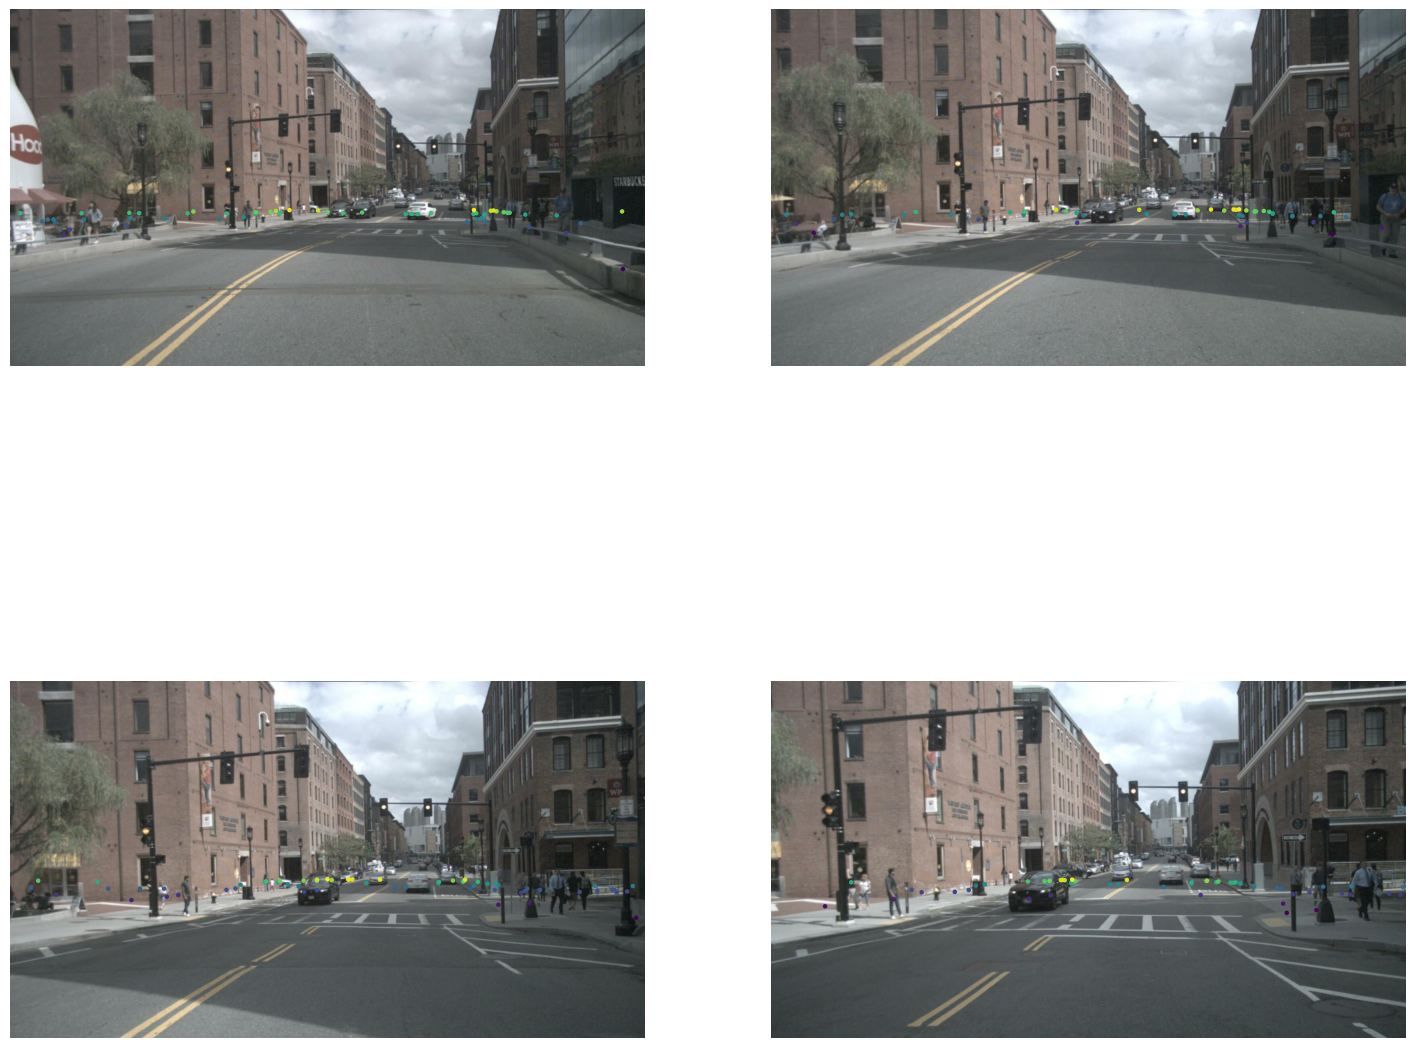

In [125]:
fig, ax = plt.subplots(2, 2, figsize=(18, 16))
# fig.canvas.set_window_title("sample token")
ax[0,0].imshow(im1)
ax[0,0].scatter(points1[0, :], points1[1, :], c=coloring1, s=5)
ax[0,0].axis('off')

ax[0,1].imshow(im2)
ax[0,1].scatter(points2[0, :], points2[1, :], c=coloring2, s=5)
ax[0,1].axis('off')

ax[1,0].imshow(im3)
ax[1,0].scatter(points3[0, :], points3[1, :], c=coloring3, s=5)
ax[1,0].axis('off')

ax[1,1].imshow(im4)
ax[1,1].scatter(cleaned_data[0, :], cleaned_data[1, :], c=cleaned_data[:,2], s=5)
ax[1,1].axis('off')



plt.show()

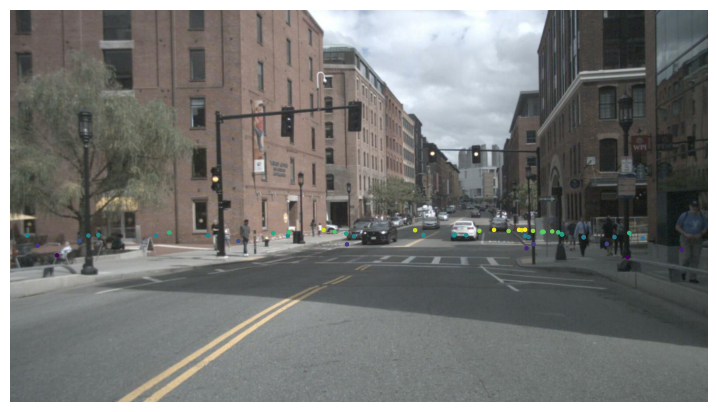

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(9, 16))
# fig.canvas.set_window_title("sample token")
ax.imshow(im2)
ax.scatter(points[0, :], points[1, :], c=coloring, s=dot_size)
ax.axis('off')
plt.show()

# Radar Clustering with DBScan

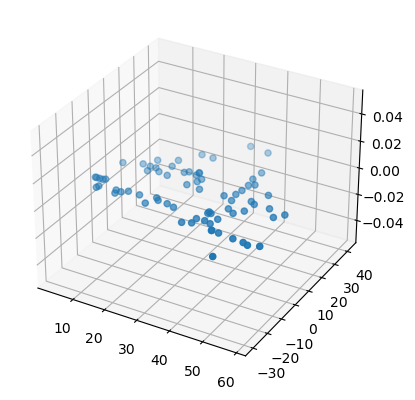

In [7]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(pc.points[0, :], pc.points[1, :], pc.points[2, :])
plt.show()

In [62]:
db_scan = DBSCAN(eps=3, min_samples=1)

In [65]:
output = db_scan.fit(pc.points[0:3, :])

In [66]:
output.labels_

array([0, 1, 2])

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(pc.points[0, :], pc.points[1, :], pc.points[2, :])
plt.show()

In [21]:
points = pc.points[:3, :]

In [24]:
# prepare model
model = DBSCAN(eps=4, min_samples=2)

In [23]:
points = points.T
points.shape

(74, 3)

In [26]:
model.fit(points)

DBSCAN(eps=4, min_samples=2)

In [27]:
labels = model.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of nose points: %d" % n_noise_)

Estimated number of clusters: 14
Estimated number of nose points: 12


In [28]:
print(labels)

[ 0  0  0  0  0 -1  1  1  2  3  3  2  2  2  3  3  3  2 -1  3 -1  4 -1  4
  5 -1  5  5  4  5  5  5  5  4  5 -1  6  6  7  8  8  8  8  8  8  7  7  8
  9  7  8  8 10  9 10 10 11  8  8  9 11 -1  8 -1 -1 -1 12 13 -1 12 13 12
 -1 12]


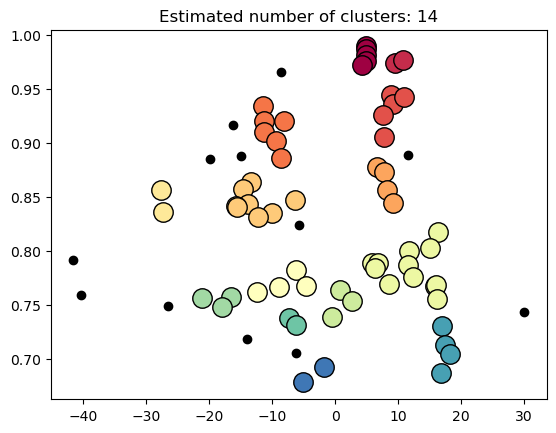

In [29]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[model.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = points[class_member_mask & core_samples_mask]

    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = points[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()

In [140]:
# %matplotlib notebook
# !pip install ipympl
%matplotlib widget

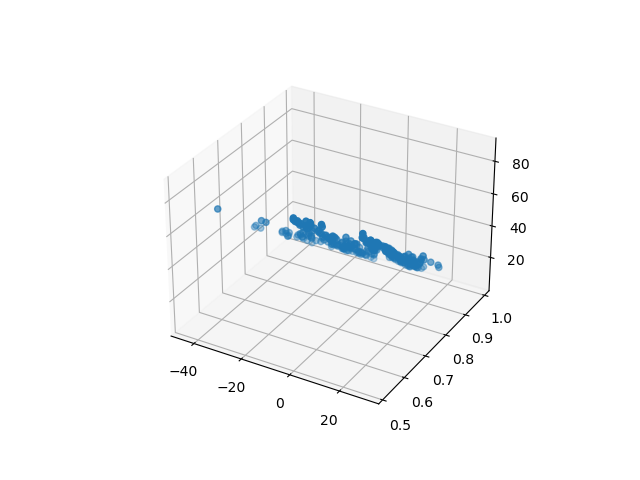

In [141]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(points_xyz[:, 0], points_xyz[:, 1], points_xyz[:, 2])
plt.show()

# Radar -> DBScan -> SORT

In [197]:
pc1.points[0:3, 0]

array([4.93104452, 0.98959228, 4.5255394 ])

In [201]:
print(pc1.points.shape)
print(points1.shape)

(18, 74)
(3, 54)


In [198]:
points1[0:3, 0]

array([1.54608054e+03, 6.55096804e+02, 1.00000000e+00])

In [199]:
int(1.54608054e+03)

1546

In [103]:
points_xyz1 = pc1.points[0:3, :].T
points_xyz1.shape

(74, 3)

In [104]:
points_xyz2 = pc2.points[0:3, :].T
points_xyz2.shape

(61, 3)

In [126]:
points_xyz = np.concatenate((pc1.points[0:3, :].T, pc2.points[0:3, :].T, pc3.points[0:3, :].T, pc4.points[0:3, :].T), axis=0)
points_xyz.shape

(282, 3)

In [127]:
points_xyz[1,:]

array([4.93191173, 0.98735175, 4.92553228])

In [367]:
cluster = DBSCAN(eps=1, min_samples=2)
output = cluster.fit(points_xyz)
output.labels_

array([-1, -1, -1,  0,  0, -1,  1, -1,  2, -1,  3, -1,  4,  5, -1, -1, -1,
       -1, -1, -1,  6,  7, -1, -1,  8, -1,  9, -1, -1, 10, -1, 11, 11, 12,
       -1, -1, -1, -1, -1, -1, 13, 13, -1, 13, -1, -1, -1, 14, -1, -1, -1,
       -1, -1, 15, -1, -1, -1, 16, 16, -1, -1, -1, -1, -1, -1, -1, 17, -1,
       -1, -1, -1, 18, -1, -1, -1,  2,  5, -1, -1, -1, -1,  6, -1,  6,  6,
        7, -1, 19,  9, 10, -1, -1, -1, -1, 20, -1, -1, -1, -1, 21, -1, -1,
       13, -1, 13, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       22, -1, -1, -1, 17, 17, -1, 23, 24, 18, -1, -1, 25, -1, -1, -1, 26,
       26,  1, -1, -1,  2, -1,  4, 27, -1, 28, -1, -1, -1, -1,  8, -1, -1,
       -1, -1, -1, -1, -1, 12, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 20,
       -1, -1, 21, -1, -1, -1, -1, 29, 14, -1, -1, -1, -1, -1, -1, 22, -1,
       17, -1, -1, -1, -1, -1, 25, -1, -1, -1, -1, 30, 30, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  2,  3, 27, -1, 28,
       -1, -1, -1, -1, 19

In [368]:
labels = output.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of nose points: %d" % n_noise_)

Estimated number of clusters: 32
Estimated number of nose points: 208


In [286]:
set(output.labels_)

{-1,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22}

In [378]:
# Abscissa is horizontal axis in a two-dimensional coordinate system, often denoted as the x-axis
# Ordinate is vertical axis in a two-dimensional coordinate system, often denoted as the y-axis
# Find abscissa and ordinate for each cluster
dets_list = []
for cluster_id in set(output.labels_):
    if cluster_id != -1:  # -1 represents noise points
        cluster_points = [point for point, label in zip(points_xyz, output.labels_) if label == cluster_id]
        x_min, x_max = min(point[0] for point in cluster_points), max(point[0] for point in cluster_points)
        y_min, y_max = min(point[1] for point in cluster_points), max(point[1] for point in cluster_points)
        z_avg = sum(point[2] for point in cluster_points)/len(cluster_points)
        # for point in cluster_points:
        #     print(point[2])
        # # z_avg = z_avg/len(cluster_points[2])
        # print(len(cluster_points))
        print(f"Cluster {cluster_id}: Abscissa ({x_min}, {x_max}), Ordinate ({y_min}, {y_max}), Z Avg ({z_avg})")
        dets_list.append([x_min, y_min, x_max, y_max])

dets_np = np.array(dets_list)

Cluster 0: Abscissa (4.337550345644862, 4.936247803060148), Ordinate (0.9722740151247741, 0.9761490781408202), Z Avg (7.2261397249076955)
Cluster 1: Abscissa (8.739272481402852, 9.53840329146444), Ordinate (0.9715641914557809, 0.9744904063585108), Z Avg (8.11638863761456)
Cluster 2: Abscissa (8.949678325268156, 10.14924223264135), Ordinate (0.9448492080944639, 0.9503587926539928), Z Avg (12.86489683284527)
Cluster 3: Abscissa (-8.24550523786549, -8.046373185997842), Ordinate (0.9177841384634623, 0.9201960953636062), Z Avg (15.153687166174851)
Cluster 4: Abscissa (10.351843144221343, 10.950973733815518), Ordinate (0.9404478150360446, 0.9432026064984147), Z Avg (13.91303906695885)
Cluster 5: Abscissa (7.354886518529117, 7.556620216214801), Ordinate (0.9257249933953747, 0.9300346419976908), Z Avg (15.919925928672418)
Cluster 6: Abscissa (-15.435946194321243, -14.437249724411174), Ordinate (0.8865325549126958, 0.8911850487609368), Z Avg (19.61820877266701)
Cluster 7: Abscissa (6.5748344317

In [379]:
dets_np.shape

(32, 4)

In [380]:
dets_np

array([[  4.33755035,   0.97227402,   4.9362478 ,   0.97614908],
       [  8.73927248,   0.97156419,   9.53840329,   0.97449041],
       [  8.94967833,   0.94484921,  10.14924223,   0.95035879],
       [ -8.24550524,   0.91778414,  -8.04637319,   0.9201961 ],
       [ 10.35184314,   0.94044782,  10.95097373,   0.94320261],
       [  7.35488652,   0.92572499,   7.55662022,   0.93003464],
       [-15.43594619,   0.88653255, -14.43724972,   0.89118505],
       [  6.57483443,   0.87781669,   7.37396524,   0.8807429 ],
       [-13.42641225,   0.86403548, -13.02771453,   0.86773912],
       [ -6.41862626,   0.84762984,  -6.41775905,   0.84987038],
       [-14.61773666,   0.84060162, -13.81860585,   0.84352783],
       [-15.81860044,   0.84086478, -15.61816756,   0.84181363],
       [  9.18870321,   0.84419661,   9.98870028,   0.84488229],
       [  5.80909139,   0.78466312,   7.20735326,   0.79431093],
       [ 11.61167752,   0.78369013,  11.81297761,   0.78687951],
       [  2.22254306,   0

In [381]:
trackers = mot_tracker.update(dets_np)
len(trackers)

30

In [382]:
for d in trackers:
    print('%d,%.2f,%.2f,%.2f,%.2f,1,-1,-1,-1'%(d[4],d[0],d[1],d[2]-d[0],d[3]-d[1]))

54,-5.11,0.58,0.60,0.00,1,-1,-1,-1
52,-35.23,0.85,0.00,0.00,1,-1,-1,-1
51,-7.84,0.89,0.20,0.00,1,-1,-1,-1
50,6.36,0.92,0.40,0.00,1,-1,-1,-1
49,8.54,0.98,0.20,0.00,1,-1,-1,-1
48,17.46,0.68,0.20,0.00,1,-1,-1,-1
47,11.05,0.70,0.80,0.00,1,-1,-1,-1
46,14.64,0.70,0.80,0.00,1,-1,-1,-1
45,15.23,0.75,0.40,0.00,1,-1,-1,-1
44,5.61,0.80,0.60,0.00,1,-1,-1,-1
43,12.80,0.83,0.80,0.00,1,-1,-1,-1
42,9.77,0.88,1.00,0.00,1,-1,-1,-1
41,17.45,0.70,0.80,0.00,1,-1,-1,-1
40,16.43,0.73,0.61,0.01,1,-1,-1,-1
39,15.82,0.77,0.20,0.00,1,-1,-1,-1
38,2.22,0.75,0.40,0.00,1,-1,-1,-1
37,11.61,0.78,0.20,0.00,1,-1,-1,-1
36,5.81,0.78,1.40,0.01,1,-1,-1,-1
35,9.19,0.84,0.80,0.00,1,-1,-1,-1
34,-15.82,0.84,0.20,0.00,1,-1,-1,-1
33,-6.42,0.85,0.00,0.00,1,-1,-1,-1
32,-13.43,0.86,0.40,0.00,1,-1,-1,-1
31,6.57,0.88,0.80,0.00,1,-1,-1,-1
30,-15.44,0.89,1.00,0.00,1,-1,-1,-1
29,7.35,0.93,0.20,0.00,1,-1,-1,-1
28,10.35,0.94,0.60,0.00,1,-1,-1,-1
27,-8.25,0.92,0.20,0.00,1,-1,-1,-1
26,8.95,0.94,1.20,0.01,1,-1,-1,-1
25,8.74,0.97,0.80,0.00,1,-

In [288]:
# Extract indices of core points (non-noise points)
core_points_mask = np.zeros_like(output.labels_, dtype=bool)
core_points_mask[output.core_sample_indices_] = True

# Extract noise points
noise_points_mask = output.labels_ == -1

# Create a new variable without noise points
cleaned_data = points_xyz[core_points_mask]

# Optionally, you can store the noise points in a separate variable
noise_data = points_xyz[noise_points_mask]

# Print the cleaned data and noise points
print("Cleaned Data:")
print(cleaned_data)
print("\nNoise Points:")
print(noise_data)

Cleaned Data:
[[  4.93104452   0.98959228   4.5255394 ]
 [  4.93191173   0.98735175   4.92553228]
 [  4.93407977   0.98175041   5.925514  ]
 [  4.9362478    0.97614908   6.92549596]
 [  4.33755035   0.97227402   7.52678348]
 [  9.53840329   0.97449041   7.91552689]
 [  8.94967833   0.94484921  13.11673086]
 [ -8.04637319   0.9201961   14.95347416]
 [  9.15314741   0.93605849  14.71626973]
 [ 10.95097373   0.94320261  13.71239389]
 [  7.55662022   0.92572499  16.31970248]
 [-11.24376269   0.91073177  16.16037479]
 [ -8.63336277   0.88607382  20.95466485]
 [-15.03638127   0.88843026  19.5685335 ]
 [  6.57483443   0.87781669  24.72171385]
 [ 11.57221925   0.88882379  23.51091839]
 [  7.77699903   0.87324387  25.71909989]
 [-13.42641225   0.86403548  24.16498967]
 [ -6.41775905   0.84762984  28.14977464]
 [-13.81860585   0.84352783  27.76579043]
 [-15.81860044   0.84181363  27.77011696]
 [-15.61816756   0.84086478  27.96968147]
 [ -5.80865501   0.8246185   32.34840168]
 [  5.80909139   0.7

In [242]:
cleaned_data.shape

(77, 3)

In [243]:
noise_data.shape

(205, 3)

In [228]:
points_xyz[:5, :]

array([[4.93104452, 0.98959228, 4.5255394 ],
       [4.93191173, 0.98735175, 4.92553228],
       [4.93407977, 0.98175041, 5.925514  ],
       [4.9362478 , 0.97614908, 6.92549596],
       [4.33755035, 0.97227402, 7.52678348]])

In [211]:
cleaned_data[:,0]

array([ -4.89421569,  -3.96694662,   6.65102781, -15.03638127,
         6.80908868,   6.41082457,  17.03507732,   9.94967562,
       -14.43724972, -14.63551456, -15.43594619,  13.59606224,
         6.61039024,  16.63334435,  10.14924223,  12.99432906,
        10.14794141,  12.79563061])

In [306]:
cleaned_data.shape

(114, 3)

In [307]:
cleaned_pc = pc2
cleaned_pc.points = cleaned_data

In [309]:
cleaned_pc

In [349]:
type(pc3.points)

numpy.ndarray

In [296]:
points_xyz_pc = pc1
points_xyz_pc.points = points_xyz

In [347]:
points_xyz_points, points_xyz_coloring = calibrate_radar_points(pc3)

depth [ 1.02370100e+01  1.04342507e+01  1.04308035e+01  8.61978498e+00
 -7.78079353e+00  1.18149375e+01  7.00324937e+00  1.20107994e+01
  8.39979232e+00  1.22059717e+01 -6.00562534e+00  1.62080130e+01
 -1.24014459e+01 -5.61528057e+00 -5.62079609e+00 -1.14214464e+01
 -3.53120707e-02  1.15673668e+01  5.55721181e-01  1.51638956e+01
  1.25597762e+01  1.69652625e+01 -5.04699846e+00  1.15521992e+01
  1.67597485e+01  1.83604275e+01  1.43521804e+01 -5.05665060e+00
  1.07432426e+01 -9.65455152e+00  1.87535301e+01  2.09569612e+01
 -1.12545401e+01 -1.32538371e+01  1.45432161e+01  1.91500798e+01
  5.93500166e+00  7.12534120e+00 -1.27804923e+00 -1.90579357e+01
 -2.42475577e+01 -2.34523900e+01 -3.36226739e+01  1.33135786e+01
 -3.00523457e+01 -6.89593664e+00  1.59080458e+01  2.33148907e+01
 -2.90492643e+00  2.61169393e+01  1.66880469e+01  4.87709530e+00
  1.78839010e+01  1.26735957e+01 -4.93731653e+00 -6.74488836e+00
  1.40515238e+01  1.72473653e+01  1.90473533e+01 -2.63433762e+01
 -7.36418803e+00 -9

In [304]:
cleaned_data_points, cleaned_data_coloring = calibrate_radar_points(pc1)

depth [-2.45833292  1.50447626 -2.44580123]
(3, 3)
(3, 3)
-----


In [299]:
cleaned_data_points.shape

(3, 0)

In [300]:
cleaned_data_points

array([], shape=(3, 0), dtype=float64)

/tmp/ipykernel_55495/1366043804.py:3: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title("sample token")


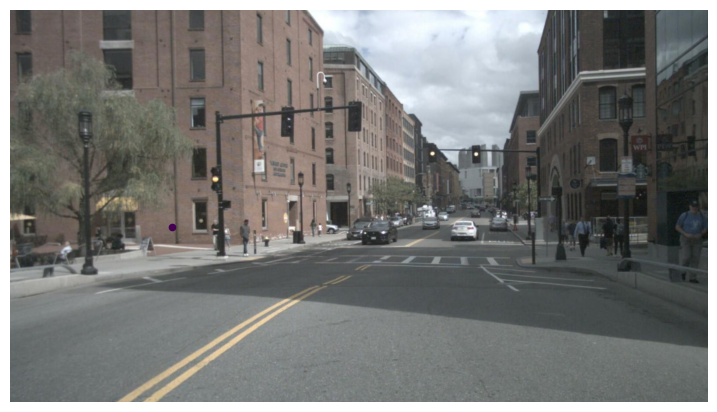

In [294]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(9, 16))
fig.canvas.set_window_title("sample token")
ax.imshow(im2)
ax.scatter(cleaned_data_points[0, :], cleaned_data_points[1, :], c=cleaned_data_coloring, s=20)
ax.axis('off')
plt.show()

In [146]:
points_xyz[0:5, :]

array([[4.93104452, 0.98959228, 4.5255394 ],
       [4.93191173, 0.98735175, 4.92553228],
       [4.93407977, 0.98175041, 5.925514  ],
       [4.9362478 , 0.97614908, 6.92549596],
       [4.33755035, 0.97227402, 7.52678348]])

In [144]:
len(labels)

282

In [143]:
points_xyz.shape

(282, 3)

In [137]:
points_xyz[:,1]

array([0.98959228, 0.98735175, 0.98175041, 0.97614908, 0.97227402,
       0.96561278, 0.97449041, 0.97663919, 0.94484921, 0.93408596,
       0.9201961 , 0.93605849, 0.94320261, 0.92572499, 0.92081417,
       0.91073177, 0.90219215, 0.90573161, 0.91652867, 0.88607382,
       0.88843026, 0.87781669, 0.88882379, 0.87324387, 0.86403548,
       0.88543643, 0.84762984, 0.85740562, 0.85678271, 0.84352783,
       0.83558214, 0.84181363, 0.84086478, 0.84419661, 0.83145599,
       0.8246185 , 0.85634571, 0.83635233, 0.78282578, 0.81787999,
       0.78862993, 0.78948703, 0.80049414, 0.78466312, 0.80323686,
       0.76739314, 0.76698269, 0.78687951, 0.76417961, 0.76182803,
       0.76974474, 0.77636252, 0.75710793, 0.75339947, 0.75652606,
       0.74806612, 0.73810686, 0.76807399, 0.76824541, 0.73945408,
       0.7312935 , 0.7496572 , 0.75609389, 0.71900678, 0.79169376,
       0.70552737, 0.73101344, 0.69249461, 0.75911428, 0.71343201,
       0.6783778 , 0.70515556, 0.74327602, 0.68715162, 0.96467

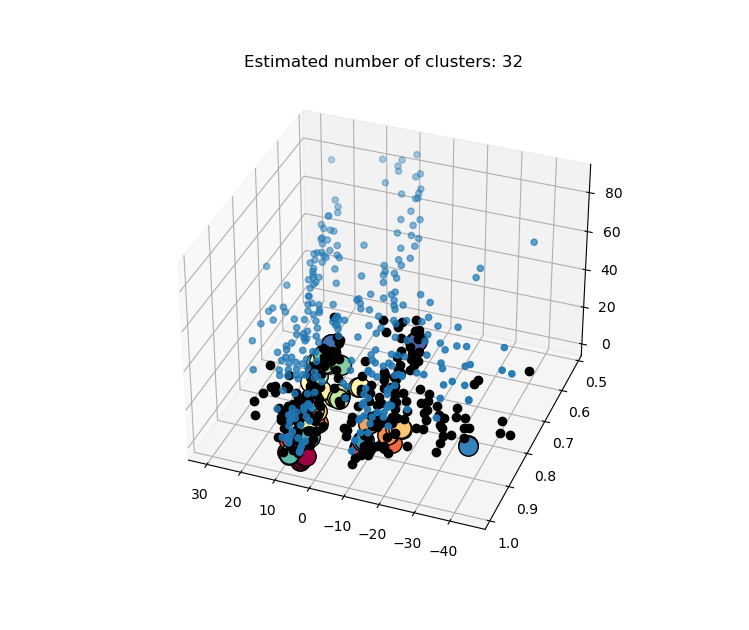

In [142]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[output.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = points_xyz[class_member_mask & core_samples_mask]

    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = points_xyz[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()

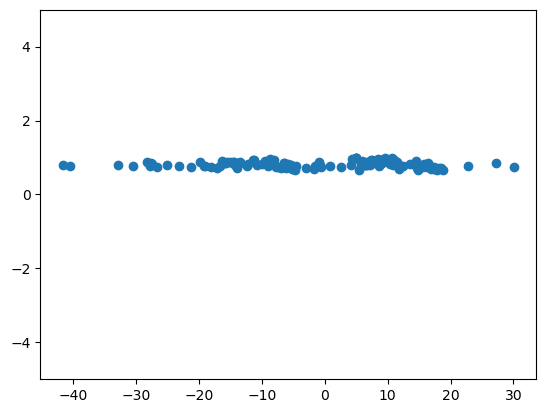

In [96]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_ylim([-5, 5])
ax.scatter(points_xyz[0, :], points_xyz[1, :])
plt.show()

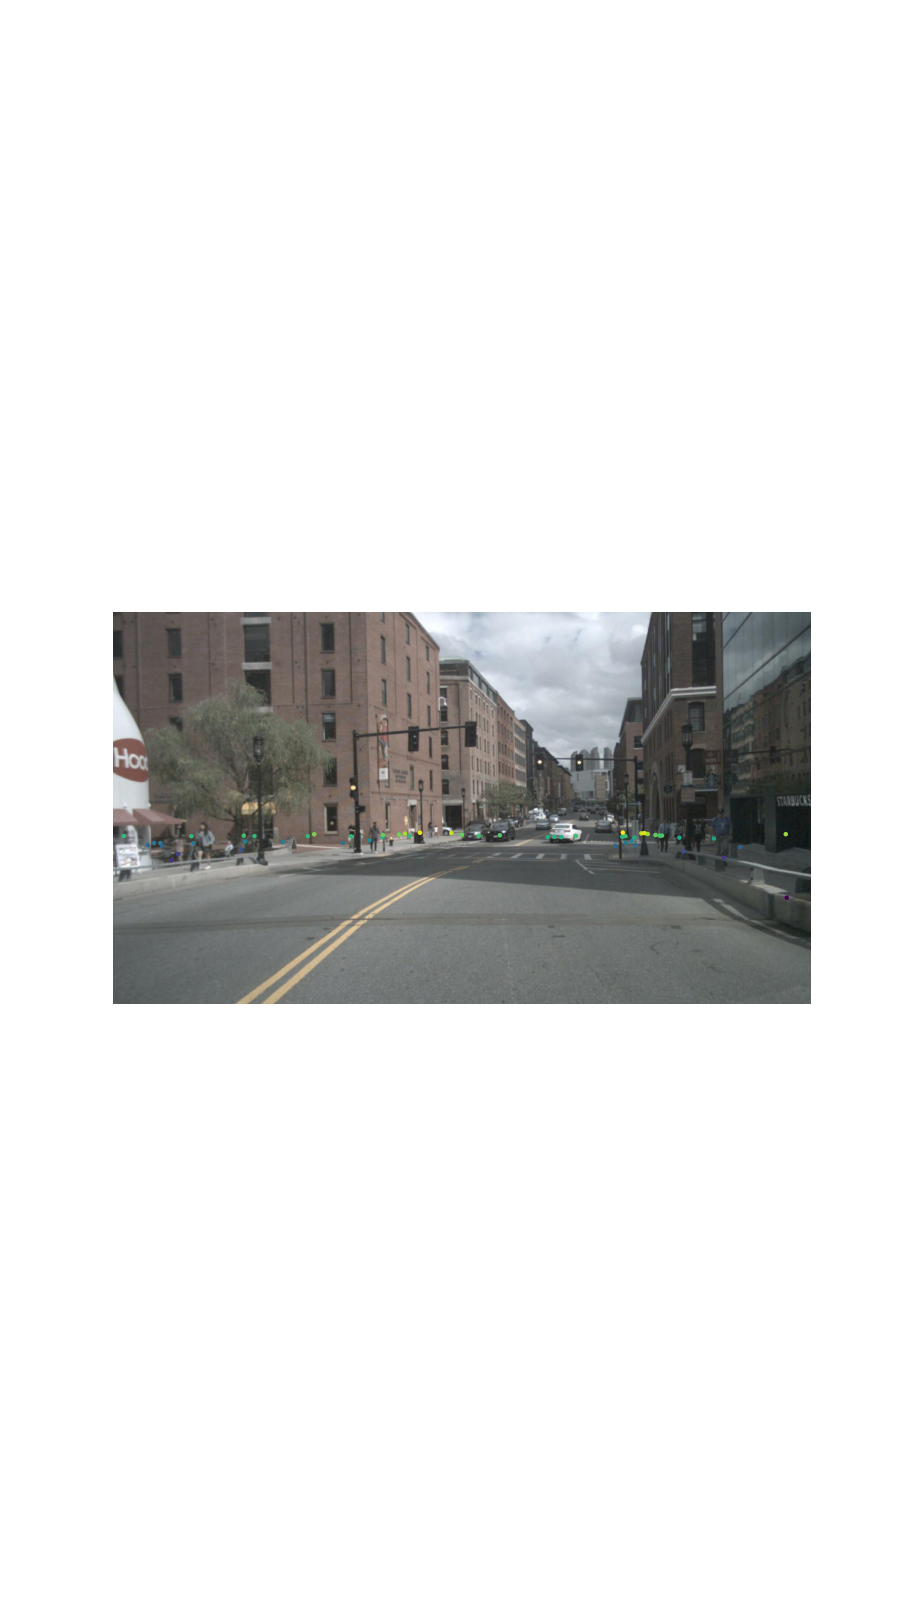

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(9, 16))
# fig.canvas.set_window_title("sample token")
ax.imshow(im)
ax.scatter(points[0, :], points[1, :], c=coloring, s=dot_size)
ax.axis('off')
plt.show()

# Widget Iterative

In [388]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [389]:
def f(x):
    return x

In [391]:
%matplotlib inline
interact(f, x=10)

interactive(children=(IntSlider(value=10, description='x', max=30, min=-10), Output()), _dom_classes=('widget-…

<function __main__.f(x)>